## 01_IMPORTS

In [57]:
#General

import pandas as pd
import matplotlib.pyplot as plt


#Embeddings
import re
from nltk.corpus import stopwords
import keras
from keras.layers import Dense, Activation, Input, Dropout
from keras.models import Model
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import gensim
from gensim.models import Word2Vec

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/flaviopfister/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## 02 LOAD DATA

In [6]:
rating_df = pd.read_csv('01_Data/books_rating.csv')

In [7]:
rating_df.head()

,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,This is only for Julie Strain fans. It's a col...
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after read...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""t..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,Philip Nel - Dr. Seuss: American IconThis is b...


In [19]:
# List of all columns
rating_df.columns

Index(['Id', 'Title', 'Price', 'User_id', 'profileName', 'review/helpfulness',
       'review/score', 'review/time', 'review/summary', 'review/text'],
      dtype='object')

array([[<Axes: title={'center': 'review/score'}>]], dtype=object)

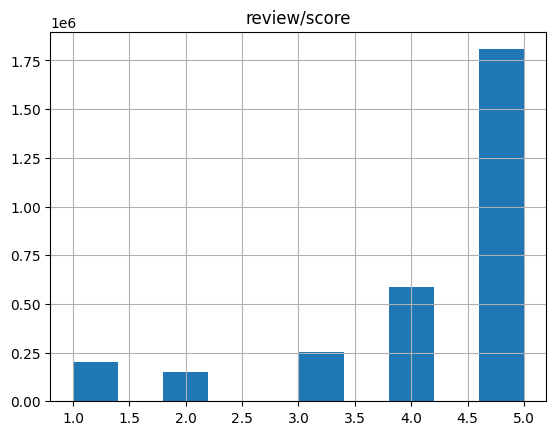

In [24]:
rating_df.hist('review/score')

In [61]:
books_df = pd.read_csv('01_Data/books_data.csv')
books_df.head()

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
0,Its Only Art If Its Well Hung!,NaN,['Julie Strain'],http://books.google.com/books/content?id=DykPA...,http://books.google.nl/books?id=DykPAAAACAAJ&d...,NaN,1996,http://books.google.nl/books?id=DykPAAAACAAJ&d...,['Comics & Graphic Novels'],NaN
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction'],NaN
4,"Nation Dance: Religion, Identity and Cultural ...",NaN,['Edward Long'],NaN,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,2003-03-01,http://books.google.nl/books?id=399SPgAACAAJ&d...,NaN,NaN


In [12]:
# get description of the book with index 1
books_df.loc[3, 'description']

'Julia Thomas finds her life spinning out of control after the death of her husband, Richard. Julia turns to her minister for comfort when she finds herself falling for him with a passion that is forbidden by the church. Heath Sparks is a man of God who is busy taking care of his quadriplegic wife who was seriously injured in a sever car accident. In an innocent effort to reach out to a lonely member of his church, Heath finds himself as the man and not the minister as Heath and Julia surrender their bodies to each other and face the wrath of God. Julia finds herself in over her head as she faces a deadly disease, the loss of her home and whispers about her wicked affair. Julia leaves the states offering her body as a living sacrifice in hopes of finding a cure while her heart remains thousands of miles away hoping to one day reunite with the man who holds it hostage.Whispers of the Wicked Saints is a once in a lifetime romance that is breath taking, defying all the rules of romance an

In [76]:
# Drop all rows with NaN values in the description column
# Word2Vec Tokenizer hat Probleme mit NaN Values

books_df = books_df.dropna(subset=['description'])
books_df

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction'],NaN
5,The Church of Christ: A Biblical Ecclesiology ...,In The Church of Christ: A Biblical Ecclesiolo...,['Everett Ferguson'],http://books.google.com/books/content?id=kVqRa...,http://books.google.nl/books?id=kVqRaiPlx88C&p...,Wm. B. Eerdmans Publishing,1996,http://books.google.nl/books?id=kVqRaiPlx88C&d...,['Religion'],5.0
8,Saint Hyacinth of Poland,The story for children 10 and up of St. Hyacin...,['Mary Fabyan Windeatt'],http://books.google.com/books/content?id=lmLqA...,http://books.google.nl/books?id=lmLqAAAACAAJ&d...,Tan Books & Pub,2009-01-01,http://books.google.nl/books?id=lmLqAAAACAAJ&d...,['Biography & Autobiography'],NaN
...,...,...,...,...,...,...,...,...,...,...
212399,The Orphan Of Ellis Island (Time Travel Advent...,"During a school trip to Ellis Island, Dominick...",['Elvira Woodruff'],http://books.google.com/books/content?id=J7M-N...,http://books.google.com/books?id=J7M-NwAACAAJ&...,Scholastic Paperbacks,2000-06-01,http://books.google.com/books?id=J7M-NwAACAAJ&...,['Juvenile Fiction'],2.0
212400,Red Boots for Christmas,Everyone in the village of Friedensdorf is hap...,NaN,http://books.google.com/books/content?id=3n8k6...,http://books.google.com/books?id=3n8k6wl4BbYC&...,NaN,1995,http://books.google.com/books?id=3n8k6wl4BbYC&...,['Juvenile Fiction'],NaN
212401,Mamaw,"Give your Mamaw a useful, beautiful and though...",['Wild Wild Cabbage'],NaN,http://books.google.com/books?id=zytVswEACAAJ&...,NaN,2018-01-17,http://books.google.com/books?id=zytVswEACAAJ&...,NaN,NaN
212402,The Autograph Man,Alex-Li Tandem sells autographs. His business ...,['Zadie Smith'],http://books.google.com/books/content?id=JM6YV...,http://books.google.com/books?id=JM6YVPx_clMC&...,Vintage,2003-08-12,https://play.google.com/store/books/details?id...,['Fiction'],19.0


In [15]:
# how many Nan values in the description column
books_df.description.isna().sum()

68442

In [17]:
# fraction of Nan values in the description column
books_df.description.isna().sum() / len(books_df)


0.32222557013992204

## Embedding of the description

In [68]:
df = pd.DataFrame({'text': ["Julia Thomas finds her life spinning out of control after the death of her husband, Richard. Julia turns to her minister for comfort when she finds herself falling for him with a passion that is forbidden by the church. Heath Sparks is a man of God who is busy taking care of his quadriplegic wife who was seriously injured in a sever car accident. In an innocent effort to reach out to a lonely member of his church, Heath finds himself as the man and not the minister as Heath and Julia surrender their bodies to each other and face the wrath of God. Julia finds herself in over her head as she faces a deadly disease, the loss of her home and whispers about her wicked affair. Julia leaves the states offering her body as a living sacrifice in hopes of finding a cure while her heart remains thousands of miles away hoping to one day reunite with the man who holds it hostage.Whispers of the Wicked Saints is a once in a lifetime romance that is breath taking, defying all the rules of romance and bending the laws of love.", "Another sentence.", "And a third one."]})


In [69]:
df

,text
0,Julia Thomas finds her life spinning out of co...
1,Another sentence.
2,And a third one.


In [70]:
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Tokenize text
    tokens = word_tokenize(text.lower())
    # Remove stopwords and punctuation
    tokens = [token for token in tokens if token not in stop_words and token not in string.punctuation]
    return tokens

df['processed_text'] = df['text'].apply(preprocess_text)

In [71]:
df

,text,processed_text
0,Julia Thomas finds her life spinning out of co...,"[julia, thomas, finds, life, spinning, control..."
1,Another sentence.,"[another, sentence]"
2,And a third one.,"[third, one]"


In [73]:
# Train Word2Vec model
model = Word2Vec(sentences=df['processed_text'], vector_size=100, window=5, min_count=1, sg=0)  # sg = 0 for CBOW, sg = 1 for skip-gram


In [74]:
def get_text_embedding(text):
    tokens = preprocess_text(text)
    embedding = []
    for token in tokens:
        if token in model.wv:
            embedding.append(model.wv[token])
    return sum(embedding) / len(embedding) if embedding else None

df['embeddings'] = df['text'].apply(get_text_embedding)

In [75]:
df

,text,processed_text,embeddings
0,Julia Thomas finds her life spinning out of co...,"[julia, thomas, finds, life, spinning, control...","[-0.0005435168, 0.0008790583, -0.000159568, 0...."
1,Another sentence.,"[another, sentence]","[0.0030553024, -0.002719168, 0.00058516674, 0...."
2,And a third one.,"[third, one]","[0.0008246605, 0.0022479205, 0.0036951376, -1...."


In [77]:
books_df['processed_desc'] = books_df['description'].apply(preprocess_text)

In [81]:
# Train Word2Vec model
model = Word2Vec(sentences=books_df['processed_desc'], vector_size=100, window=5, min_count=1, sg=0)  # sg = 0 for CBOW, sg = 1 for skip-gram

In [86]:
# Function to get the text embedding from the book descriptions

def get_text_embedding(text):
    tokens = preprocess_text(text)
    embedding = []
    for token in tokens:
        if token in model.wv:
            embedding.append(model.wv[token])
    return sum(embedding) / len(embedding) if embedding else None

books_df['embeddings'] = books_df['description'].apply(get_text_embedding)

In [87]:
books_df

,Title,description,authors,image,previewLink,publisher,publishedDate,infoLink,categories,ratingsCount,processed_desc,embeddings
1,Dr. Seuss: American Icon,Philip Nel takes a fascinating look into the k...,['Philip Nel'],http://books.google.com/books/content?id=IjvHQ...,http://books.google.nl/books?id=IjvHQsCn_pgC&p...,A&C Black,2005-01-01,http://books.google.nl/books?id=IjvHQsCn_pgC&d...,['Biography & Autobiography'],NaN,"[philip, nel, takes, fascinating, look, key, a...","[-0.35528383, 0.31161073, -0.041549966, 0.5103..."
2,Wonderful Worship in Smaller Churches,This resource includes twelve principles in un...,['David R. Ray'],http://books.google.com/books/content?id=2tsDA...,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,NaN,2000,http://books.google.nl/books?id=2tsDAAAACAAJ&d...,['Religion'],NaN,"[resource, includes, twelve, principles, under...","[-0.1480653, -0.64452076, -0.13215962, -0.3027..."
3,Whispers of the Wicked Saints,Julia Thomas finds her life spinning out of co...,['Veronica Haddon'],http://books.google.com/books/content?id=aRSIg...,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,iUniverse,2005-02,http://books.google.nl/books?id=aRSIgJlq6JwC&d...,['Fiction'],NaN,"[julia, thomas, finds, life, spinning, control...","[-1.2744929, -0.26509693, 1.2318112, -0.462519..."
5,The Church of Christ: A Biblical Ecclesiology ...,In The Church of Christ: A Biblical Ecclesiolo...,['Everett Ferguson'],http://books.google.com/books/content?id=kVqRa...,http://books.google.nl/books?id=kVqRaiPlx88C&p...,Wm. B. Eerdmans Publishing,1996,http://books.google.nl/books?id=kVqRaiPlx88C&d...,['Religion'],5.0,"[church, christ, biblical, ecclesiology, today...","[0.21447034, -0.48086992, -0.17060585, -0.2400..."
8,Saint Hyacinth of Poland,The story for children 10 and up of St. Hyacin...,['Mary Fabyan Windeatt'],http://books.google.com/books/content?id=lmLqA...,http://books.google.nl/books?id=lmLqAAAACAAJ&d...,Tan Books & Pub,2009-01-01,http://books.google.nl/books?id=lmLqAAAACAAJ&d...,['Biography & Autobiography'],NaN,"[story, children, 10, st., hyacinth, dominican...","[-0.5868648, -0.021066764, 0.48399183, -0.2855..."
...,...,...,...,...,...,...,...,...,...,...,...,...
212399,The Orphan Of Ellis Island (Time Travel Advent...,"During a school trip to Ellis Island, Dominick...",['Elvira Woodruff'],http://books.google.com/books/content?id=J7M-N...,http://books.google.com/books?id=J7M-NwAACAAJ&...,Scholastic Paperbacks,2000-06-01,http://books.google.com/books?id=J7M-NwAACAAJ&...,['Juvenile Fiction'],2.0,"[school, trip, ellis, island, dominick, avaro,...","[-1.4576176, 0.30339834, 0.83842486, -0.772673..."
212400,Red Boots for Christmas,Everyone in the village of Friedensdorf is hap...,NaN,http://books.google.com/books/content?id=3n8k6...,http://books.google.com/books?id=3n8k6wl4BbYC&...,NaN,1995,http://books.google.com/books?id=3n8k6wl4BbYC&...,['Juvenile Fiction'],NaN,"[everyone, village, friedensdorf, happily, pre...","[-0.82504356, 0.1266477, 0.85221195, -0.283072..."
212401,Mamaw,"Give your Mamaw a useful, beautiful and though...",['Wild Wild Cabbage'],NaN,http://books.google.com/books?id=zytVswEACAAJ&...,NaN,2018-01-17,http://books.google.com/books?id=zytVswEACAAJ&...,NaN,NaN,"[give, mamaw, useful, beautiful, thoughtful, g...","[-0.67966425, 0.29081526, 0.10049067, 0.347693..."
212402,The Autograph Man,Alex-Li Tandem sells autographs. His business ...,['Zadie Smith'],http://books.google.com/books/content?id=JM6YV...,http://books.google.com/books?id=JM6YVPx_clMC&...,Vintage,2003-08-12,https://play.google.com/store/books/details?id...,['Fiction'],19.0,"[alex-li, tandem, sells, autographs, business,...","[-0.8779723, 0.21024781, 0.33945814, 0.2078855..."


In [90]:
books_df.loc[3, 'infoLink']

'http://books.google.nl/books?id=aRSIgJlq6JwC&dq=Whispers+of+the+Wicked+Saints&hl=&source=gbs_api'